In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import kl_div
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
import os
import pandas as pd
import sys
import numpy as np
import glob
import torch

sys.path.insert(1,"/home/showalte/research/prob_seq_queries/")
from seq_queries.utils import read_pkl, write_pkl

In [4]:
# data = read_pkl("../data/beam_search_is_hybrid/shakespeare/val_dl/val-dl_shakespeare_beam-search-is-hybrid_18h_20s_10mc.pkl")
raw_data_amazon = read_pkl("../data/efficiency_ablation/amazon/val_dl/val-dl_amazon_efficiency-ablation_5h_21s_50mc_pgt_1000q.pkl")
raw_data_shakespeare = read_pkl("../data/efficiency_ablation/shakespeare/val_dl/val-dl_shakespeare_efficiency-ablation_5h_21s_50mc_pgt_1000q.pkl")
raw_data_apps = read_pkl("../data/efficiency_ablation/apps/val_dl/val-dl_apps_efficiency-ablation_5h_21s_50mc_pgt_1000q.pkl")
raw_data_moocs = read_pkl("../data/efficiency_ablation/moocs/val_dl/val-dl_moocs_efficiency-ablation_5h_21s_50mc_pgt_1000q.pkl")

In [7]:
data = {
    "amazon":raw_data_amazon['efficiency'],
    "shakespeare":raw_data_shakespeare['efficiency'],
    "apps":raw_data_apps['efficiency'],
    "moocs":raw_data_moocs['efficiency'],
}

In [8]:
print(data['amazon'].shape)

torch.Size([1000, 17, 30])


In [83]:
def compute_mean_kl(estimates, pgts):
    return np.array([
        entropy(estimate,qk=pgt) for 
        estimate,pgt in zip(estimates,pgts)
    ]).mean()

def compute_rae(estimates,gts, tol=1e-20):
    res = []
    for estimate,gt in zip(estimates,gts):
        res.append((np.abs(estimate - gt) + tol) / (gt + tol))
        # print(res[-1].shape)
        
    res = np.concatenate(res)
    return np.median(res)
    # return res.mean()

def make_query_budget_table(
    iqp,
    sub_estimates=[10,30,50,100,300,500,1000,3000,5000,10000],
    seq_lens=[2,3,4,5,10,20,30,40,50,60,70,80,90,100],
 ):
    pgt, iqp = iqp[:,-1,:,:], iqp[:,:-1,:,:]
    num_budgets = iqp.shape[1]-1
    query_dict = {}
    for i, seq_len in enumerate(seq_lens):
        query_dict[seq_len] = []
        for j, est in enumerate(sub_estimates):
            query_dict[seq_len].append(
                compute_rae(
                    iqp[:,j,i,:],
                    pgt[:,i,:],
                )
            )
            # sys.exit(1)
    
    df = pd.DataFrame.from_dict(query_dict)
    df.index = sub_estimates
    return df
    

In [84]:
res_dict = {}
for key in data:
    res_dict[key] = make_query_budget_table(data[key])

In [89]:
included_budgets = [10,100,1000,10000]
included_lens = [2,5,10,20,40,60,80,100]
for k in res_dict:
    formatted = (res_dict[k].round(4))*100
    formatted = formatted.loc[included_budgets,included_lens]
    formatted = formatted.style.format(precision=2)
    print(k,formatted.to_latex())

amazon \begin{tabular}{lrrrrrrrr}
 & 2 & 5 & 10 & 20 & 40 & 60 & 80 & 100 \\
10 & 31.35 & 40.33 & 44.39 & 43.48 & 45.98 & 45.84 & 49.44 & 50.05 \\
100 & 13.29 & 17.12 & 18.73 & 19.46 & 20.41 & 21.65 & 21.82 & 21.86 \\
1000 & 4.94 & 6.38 & 7.06 & 7.33 & 7.26 & 6.99 & 7.13 & 6.82 \\
10000 & 1.60 & 2.05 & 2.21 & 2.34 & 2.20 & 2.13 & 2.06 & 2.10 \\
\end{tabular}

shakespeare \begin{tabular}{lrrrrrrrr}
 & 2 & 5 & 10 & 20 & 40 & 60 & 80 & 100 \\
10 & 79.84 & 79.99 & 83.53 & 85.29 & 83.53 & 84.00 & 85.82 & 85.15 \\
100 & 28.66 & 32.85 & 39.25 & 40.66 & 38.78 & 41.51 & 39.71 & 40.07 \\
1000 & 8.61 & 10.99 & 13.29 & 13.52 & 13.78 & 13.89 & 13.64 & 14.10 \\
10000 & 2.77 & 3.48 & 4.28 & 4.34 & 4.32 & 4.33 & 4.34 & 4.30 \\
\end{tabular}

apps \begin{tabular}{lrrrrrrrr}
 & 2 & 5 & 10 & 20 & 40 & 60 & 80 & 100 \\
10 & 66.21 & 84.93 & 92.92 & 96.96 & 98.41 & 99.00 & 99.19 & 99.32 \\
100 & 62.36 & 80.94 & 89.79 & 94.00 & 96.16 & 97.05 & 97.38 & 97.66 \\
1000 & 47.96 & 59.14 & 69.10 & 75.45 & 74.79 & 7

In [9]:
for dataset,data_vals in data.items():
    torch.save(data_vals, f'{dataset}_efficiency-ablation_probs.pt')

In [10]:
from scipy.special import kl_div
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score

In [7]:
PGT = data[:,-1,:,:]
PGT.shape

torch.Size([100, 14, 30])

In [16]:
test_sample = data[:,:-1,:,:]
test_pgt = PGT[:]
print(test_sample.shape)
test_pgt.shape

torch.Size([100, 10, 14, 30])


torch.Size([100, 14, 30])

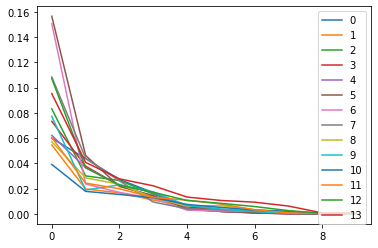

In [15]:
import matplotlib.pyplot as plt
for j in range(PGT.shape[1]):
    plt.plot(range(10),
             [
                entropy(test_pgt[j],qk=test_sample[i,j]) 
                 for i in range(test_sample.shape[0])],
            label=j)
plt.legend()

In [28]:
import glob

paths = glob.glob("../data/beam_search_is_hybrid/shakespeare/val_dl/val-dl_shakespeare_*.pkl")
for p in paths:
    # print(p)
    data = read_pkl(p)
    excluded_tokens = data['excluded_tokens']
    excluded_tokens = excluded_tokens.
    print(data.keys())
    print(data['model_iters'].min())
    break
    # data['metadata']['text_dict']['text'] = None
    # write_pkl(data,p)

dict_keys(['bs_lower_bound', 'is_estimate', 'hybrid_bs_is_estimate', 'model_runs', 'hybrid_var', 'hybrid_mean', 'num_beams', 'true_coverage', 'restricted_coverage', 'metadata', 'excluded_terms'])


KeyError: 'model_iters'

In [20]:

# test = torch.gather(data['hybrid_bs_is_estimate'],-1,data['excluded_terms'].reshape(-1,1,1))
# print(test.shape)
for d in data.keys():
    print(d,data[d].shape)
# data['sample_est_mean']

sample_estimates torch.Size([2287, 5, 68])
q_log_prob torch.Size([2287, 0])
sample_est_var torch.Size([2287, 5, 68])
sample_est_mean torch.Size([2287, 0])


AttributeError: 'dict' object has no attribute 'shape'

In [1]:
# data['metadata']